In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import tensorflow as tf 
from tensorflow import keras
from numpy import argmax
from keras.utils import to_categorical
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras import Model
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import pdb

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [19]:
mnist=tf.keras.datasets.mnist
k = mnist.load_data()
((train_mnist_image, train_mnist_label), _) = k
train_mnist_image = train_mnist_image.reshape(train_mnist_image.shape[0], 28, 28, 1).astype('float32')
train_mnist_image = (train_mnist_image - 127.5)/127.5
print(train_mnist_image.shape)

(60000, 28, 28, 1)


In [20]:
def gen_image(arr):
    two_d = (np.reshape(arr, (28, 28)))
    plt.imshow(two_d, interpolation='nearest') #cmap=plt.get_cmap('gray')
    return plt

In [21]:
def batch_generator(X, batch_size = 128):
    input_shape = X.shape[0]
    image_list = np.array(range(input_shape))
    np.random.shuffle(image_list)
    iterations = int(input_shape / batch_size)
    image = []
    for i in range(iterations-1):
        batch_list = image_list[i * (batch_size) : (i+1) * (batch_size)]
        image.append(X[batch_list])
    return np.array(image)

In [22]:
def generator_model():
    X_gen_input = Input(shape=(10))
    X = Dense(256, activation='relu')(X_gen_input)
    X = Dropout(.5)(X)
    X = Dense(144, activation='relu')(X)
    X = Reshape((12, 12, 1))(X)
    
    X = Conv2DTranspose(16, (3, 3), strides=(1, 1), padding='valid', activation='relu')(X)
    X = UpSampling2D(size=(2, 2), interpolation='nearest')(X)
    
    X = Conv2DTranspose(8, (3, 3), strides=(1, 1), padding='same', activation='relu')(X)
    X = Dropout(.5)(X)
    
    X = Conv2DTranspose(4, (3, 3), strides=(1, 1), padding='same', activation='relu')(X)
    X = Dropout(.5)(X)
    
    X = Conv2DTranspose(2, (3, 3), strides=(1, 1), padding='same', activation='relu')(X)
    X = Dropout(.5)(X)
    
    output = Conv2DTranspose(1, (3, 3), strides=(1, 1), padding='same', activation='tanh')(X)
    
    model = Model(inputs = X_gen_input, outputs = output)
    return model

In [23]:
def discriminator_model():
    X_dis_input = Input(shape=(28, 28, 1))
    X = Conv2D(2, (3, 3), strides=(1, 1), padding='same', activation='relu')(X_dis_input)
    X = Conv2D(4, (3, 3), strides=(1, 1), padding='same', activation='relu')(X)
    X = Conv2D(8, (3, 3), strides=(1, 1), padding='same', activation='relu')(X)
    X = MaxPooling2D((2, 2), strides=(1, 1))(X)
    X = Conv2D(16, (3, 3), strides=(1, 1), padding='valid', activation='relu')(X)
    X = Flatten()(X)
                                                                             
    X = Dense(256, activation='relu')(X)
    X = Dropout(.5)(X)
    X = Dense(128, activation = 'relu')(X)
    X = Dropout(.5)(X)
    output_dis = Dense(1, activation = 'sigmoid')(X)
    
    model = Model(inputs = X_dis_input, outputs = output_dis)
    return model

In [33]:
generator = generator_model()
discriminator = discriminator_model()

In [34]:
batch_size = 128
EPOCHS = 100

In [35]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [36]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [37]:
def train_step(train_mnist_images):
        shape = train_mnist_images.shape
#         print(train_mnist_images.shape)
#         print(shape[0])
        noise_batch = np.random.normal(0, 1, (shape[0], 10))
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            
            fake_image_batch = generator(noise_batch, training=True)
            real_output = discriminator(train_mnist_images, training=True)
            fake_output = discriminator(fake_image_batch, training=True)
            
            real_disc_loss = cross_entropy(tf.ones_like(real_output), real_output)
            fake_disc_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
            
            gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
            discriminator_loss  = (real_disc_loss + fake_disc_loss) 
            
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
        
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        return [gen_loss, discriminator_loss]

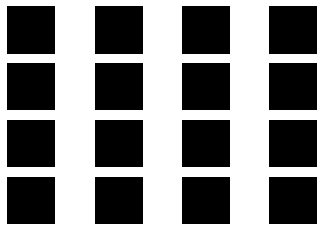

total_discriminator_loss: tf.Tensor(0.00047565106, shape=(), dtype=float32)
epoch: 0


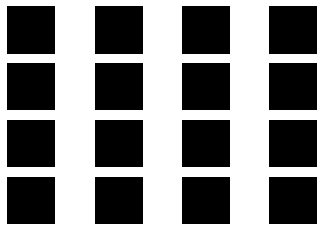

total_discriminator_loss: tf.Tensor(5.6276727e-05, shape=(), dtype=float32)
epoch: 1


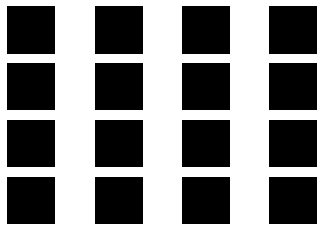

total_discriminator_loss: tf.Tensor(1.1924397e-05, shape=(), dtype=float32)
epoch: 2


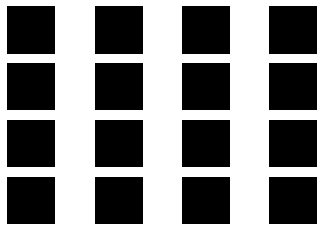

total_discriminator_loss: tf.Tensor(5.592393e-06, shape=(), dtype=float32)
epoch: 3


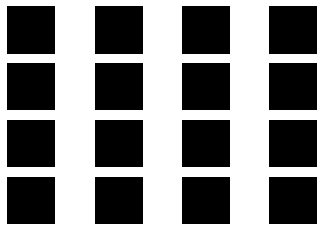

total_discriminator_loss: tf.Tensor(2.5833679e-06, shape=(), dtype=float32)
epoch: 4


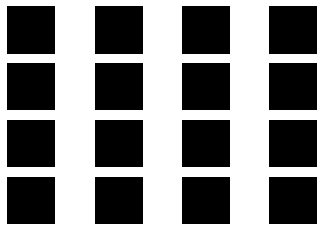

total_discriminator_loss: tf.Tensor(6.472708e-07, shape=(), dtype=float32)
epoch: 5


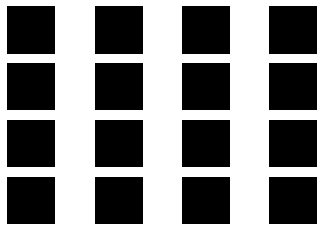

total_discriminator_loss: tf.Tensor(2.4612882e-07, shape=(), dtype=float32)
epoch: 6


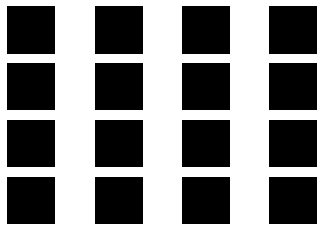

total_discriminator_loss: tf.Tensor(9.2051937e-07, shape=(), dtype=float32)
epoch: 7


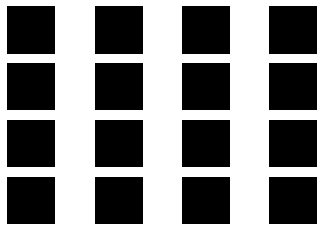

total_discriminator_loss: tf.Tensor(2.0547718e-06, shape=(), dtype=float32)
epoch: 8


In [ ]:
len_train_set = train_mnist_image.shape[0]
fake_label = np.zeros((batch_size, 1))
real_label = np.ones((batch_size, 1))
for i in range(EPOCHS):
    image_batches = batch_generator(train_mnist_image , batch_size)
    for real_image_batch in image_batches:
        [generator_loss, discriminator_loss] = train_step(real_image_batch)
    
    predictions = generator(np.random.normal(0, 1, (batch_size, 10)), training=False)
    for j in range(predictions[0:16].shape[0]):
        plt.subplot(4, 4, j+1)
        plt.imshow(predictions[j, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(i))
    plt.show()
    print("total_discriminator_loss: " + str(discriminator_loss))
    print("epoch: " + str(i))

In [ ]:
i=0
for image in images: # how many imgs will show from the 3x3 grid
    fig, axs = plt.subplots(nrows=1, sharex=True, figsize=(2, 2))
    two_d = (np.reshape(image, (28, 28)))
    axs.imshow(two_d, interpolation='nearest', cmap=plt.get_cmap('gray'))
    i=i+1
    if i%100 == 0:
        a=input()
        if a=='q':
            break 

In [15]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 244412869876514494
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6910041152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5429016145505624272
physical_device_desc: "device: 0, name: GeForce RTX 3070, pci bus id: 0000:23:00.0, compute capability: 8.6"
]


NameError: name 'get_available_gpus' is not defined

In [45]:
with tf.device('/device:XLA_GPU:0'):
  a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')

In [46]:
a

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>